# HCP1200 Exploratory Data Analysis

## Setup 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

  import numpy.matlib as npm

  autumn = cm.get_cmap('autumn', 256)

  winter = cm.get_cmap('winter_r', 256)



In [3]:
from models import *
from data import * 
from env import *
from sim import *

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

import sys


### Paths and metadata

In [4]:
# Set paths
GeneEx2Conn_path = os.path.normpath(os.getcwd())
HCP1200_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1'
print(GeneEx2Conn_path)
print(HCP1200_path)

# Get list of subjects from HCP1200 directory
unique_subject_ids = [x.split('-')[1] for x in os.listdir(HCP1200_path) if x.startswith('sub-')]
print(f"Number of subjects: {len(unique_subject_ids)}")

# Load Schaefer 456 parcellation info
schaef456_atlas_info = pd.read_csv('./data/UKBB/atlas-4S456Parcels_dseg_reformatted.csv')

# Set network labels for cerebellum and subcortical regions
schaef456_atlas_info.loc[schaef456_atlas_info['atlas_name'] == 'Cerebellum', 'network_label'] = 'Cerebellum'
schaef456_atlas_info.loc[(schaef456_atlas_info['network_label'].isna()) & 
                        (schaef456_atlas_info['atlas_name'] != 'Cerebellum'), 'network_label'] = 'Subcortical'

# Create labels and network labels
schaef456_labels = schaef456_atlas_info['label'].tolist()
schaef456_network_labels = schaef456_atlas_info['network_label'].values

# Print some basic info
print(f"\nSchaefer 456 Parcellation Info:")
print(f"Number of ROIs: {len(schaef456_labels)}")
print("\nNetwork distribution:")
network_counts = pd.Series(schaef456_network_labels).value_counts()
for network, count in network_counts.items():
    print(f"{network}: {count} ROIs ({count/len(schaef456_labels)*100:.1f}%)")

/scratch/asr655/neuroinformatics/GeneEx2Conn
/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1
Number of subjects: 1096

Schaefer 456 Parcellation Info:
Number of ROIs: 456

Network distribution:
Default: 91 ROIs (20.0%)
SomMot: 77 ROIs (16.9%)
Vis: 61 ROIs (13.4%)
Cont: 52 ROIs (11.4%)
SalVentAttn: 47 ROIs (10.3%)
Subcortical: 46 ROIs (10.1%)
DorsAttn: 46 ROIs (10.1%)
Limbic: 26 ROIs (5.7%)
Cerebellum: 10 ROIs (2.2%)


In [5]:
print("\nHCP1200 Data Path:")
print(HCP1200_path)

print("\nNumber of Unique Subject IDs:", len(unique_subject_ids))
print("First 10 Subject IDs:", unique_subject_ids[:10])

print("\nSchaefer 456 Labels:")
print("Total number of labels:", len(schaef456_labels))
print("First 10 labels:", schaef456_labels[:10])

print("\nNetwork Label Distribution:")
unique_networks = np.unique(schaef456_network_labels)
for network in unique_networks:
    count = np.sum(schaef456_network_labels == network)
    print(f"{network}: {count} regions ({count/len(schaef456_network_labels)*100:.1f}%)")


HCP1200 Data Path:
/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1

Number of Unique Subject IDs: 1096
First 10 Subject IDs: ['749361', '191942', '983773', '387959', '137431', '193441', '792867', '295146', '134627', '248339']

Schaefer 456 Labels:
Total number of labels: 456
First 10 labels: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10']

Network Label Distribution:
Cerebellum: 10 regions (2.2%)
Cont: 52 regions (11.4%)
Default: 91 regions (20.0%)
DorsAttn: 46 regions (10.1%)
Limbic: 26 regions (5.7%)
SalVentAttn: 47 regions (10.3%)
SomMot: 77 regions (16.9%)
Subcortical: 46 regions (10.1%)
Vis: 61 regions (13.4%)


  plt.tight_layout()



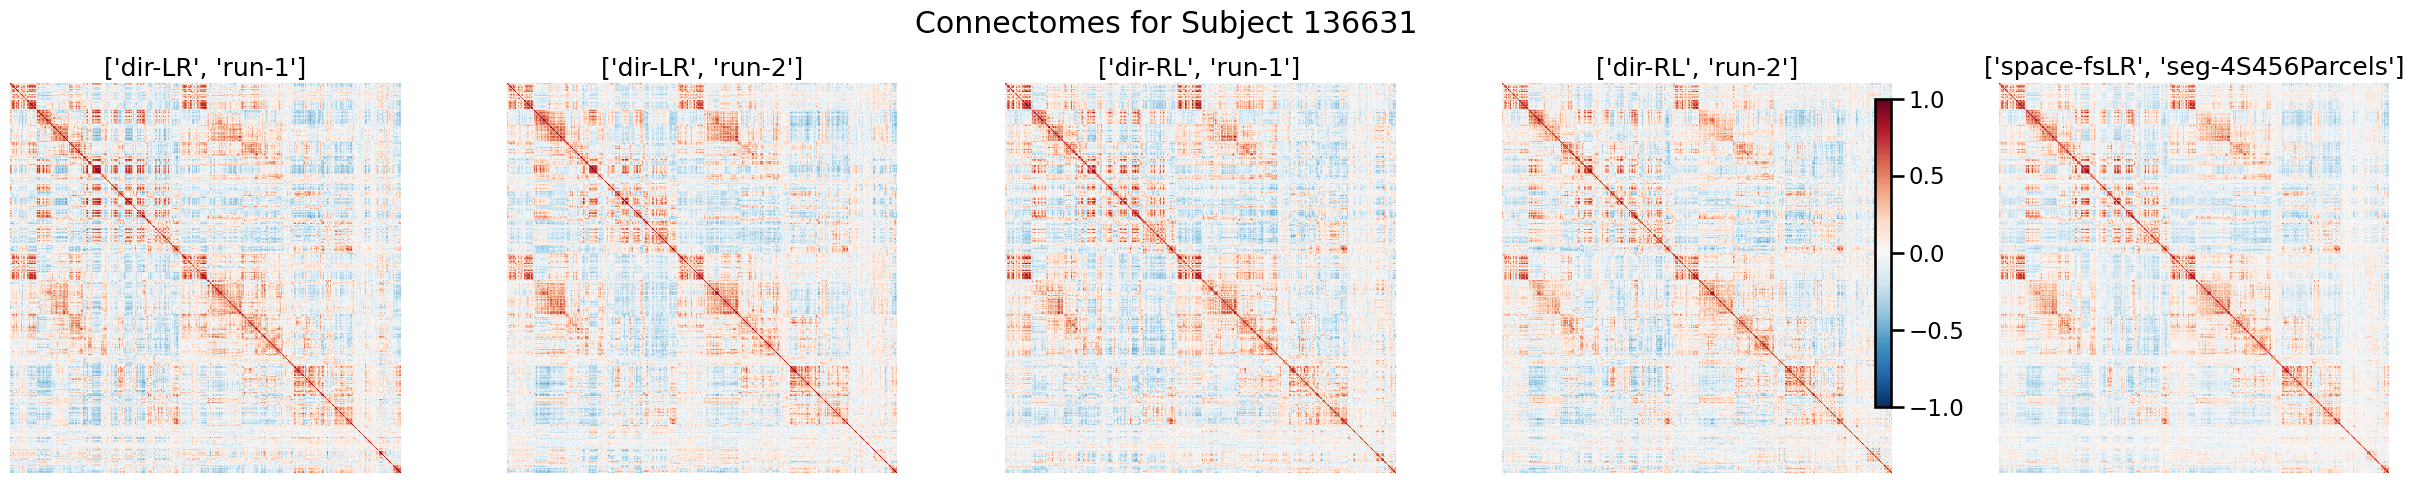

In [6]:
# Load and visualize individual run connectomes for a sample subject
sample_subject = '136631'
run_paths = [
    f'sub-{sample_subject}_task-rest_dir-LR_run-1_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv',
    f'sub-{sample_subject}_task-rest_dir-LR_run-2_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv', 
    f'sub-{sample_subject}_task-rest_dir-RL_run-1_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv',
    f'sub-{sample_subject}_task-rest_dir-RL_run-2_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv',
    f'sub-{sample_subject}_task-rest_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
]

# Create figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle(f'Connectomes for Subject {sample_subject}')

# Load and plot each connectome
for i, run_path in enumerate(run_paths):
    full_path = os.path.join(HCP1200_path, f'sub-{sample_subject}', 'func', run_path)
    connectome = pd.read_csv(full_path, sep='\t', index_col=0).values
    
    im = axes[i].imshow(connectome, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[i].set_title(run_path.split('_')[2:4])
    axes[i].axis('off')

# Add colorbar
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


## Load data

### Load all subjects and generate population average connectomes

In [9]:
def compute_HCP1200_population_average_connectome(subject_list, data_path, verbose=True):
    """
    Compute population average connectome from a list of subjects.
    
    Parameters
    ----------
    subject_list : list
        List of subject IDs (e.g. ['032311', '032309', etc])
    data_path : str
        Path to data directory
    verbose : bool, optional
        Whether to print progress, by default True
        
    Returns
    -------
    tuple
        (population average connectome matrix,
         list of individual subject connectomes)
    """
    # Initialize list to store connectomes
    connectomes = []
    n_skipped = 0

    # Collect all valid connectomes
    for i, subject_id in enumerate(subject_list):
        if verbose and i % 100 == 0:
            print(f"Loading subject {i}/{len(subject_list)}")
            
        # Get connectome path
        fc_path = os.path.join(data_path, f'sub-{subject_id}', 'func', 
                             f'sub-{subject_id}_task-rest_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv')
        
        try:
            # Load connectome - data is tab-separated with header
            curr_mat = pd.read_csv(fc_path, sep='\t', index_col=0).values
            connectomes.append(curr_mat)
        except Exception as e:
            if verbose:
                print(f"Error processing subject {subject_id}: {str(e)}")
            n_skipped += 1
            continue

    # Count connectomes with NaN values
    nan_count = sum(np.any(np.isnan(conn)) for conn in connectomes)
    if verbose:
        print(f"Number of connectomes with NaN values: {nan_count} out of {len(connectomes)} total connectomes")
        print(f"Number of subjects skipped: {n_skipped}")

    # Compute average
    pop_avg = np.nanmean(connectomes, axis=0)
    
    return pop_avg, connectomes

In [10]:
unique_subject_ids

['749361',
 '191942',
 '983773',
 '387959',
 '137431',
 '193441',
 '792867',
 '295146',
 '134627',
 '248339',
 '510225',
 '617748',
 '275645',
 '105014',
 '103010',
 '200210',
 '111716',
 '187345',
 '268749',
 '124826',
 '199453',
 '390645',
 '163129',
 '118831',
 '541640',
 '208428',
 '638049',
 '922854',
 '123521',
 '206727',
 '597869',
 '802844',
 '304020',
 '136732',
 '856463',
 '168139',
 '158843',
 '122822',
 '869472',
 '465852',
 '181232',
 '145834',
 '224022',
 '570243',
 '462139',
 '165941',
 '930449',
 '392750',
 '579867',
 '588565',
 '497865',
 '126325',
 '727654',
 '627549',
 '701535',
 '910443',
 '200008',
 '117021',
 '896879',
 '147636',
 '518746',
 '284646',
 '118932',
 '622236',
 '121416',
 '609143',
 '131924',
 '151829',
 '204420',
 '751550',
 '118730',
 '113821',
 '557857',
 '495255',
 '197651',
 '177746',
 '148840',
 '158540',
 '737960',
 '239944',
 '792564',
 '102715',
 '151526',
 '351938',
 '309636',
 '250427',
 '536647',
 '107725',
 '413934',
 '124220',
 '844961',

In [11]:
HCP1200_connectome_mu, HCP1200_connectomes = compute_HCP1200_population_average_connectome(
    subject_list=unique_subject_ids,
    data_path=HCP1200_path
)
# Remove subjects with missing data
unique_subject_ids.remove('693461')
unique_subject_ids.remove('150019')
unique_subject_ids.remove('190132')
unique_subject_ids.remove('121820')
unique_subject_ids.remove('116120')
unique_subject_ids.remove('173233')

Loading subject 0/1096
Loading subject 100/1096
Error processing subject 693461: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1/sub-693461/func/sub-693461_task-rest_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 200/1096
Loading subject 300/1096
Loading subject 400/1096
Loading subject 500/1096
Error processing subject 150019: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1/sub-150019/func/sub-150019_task-rest_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
Error processing subject 190132: [Errno 2] No such file or directory: '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/xcpd-0-9-1/sub-190132/func/sub-190132_task-rest_space-fsLR_seg-4S456Parcels_stat-pearsoncorrelation_relmat.tsv'
Loading subject 600/1096
Loading subject 700/1096
Error processing subject 121820: [Errno 2] No such file or direc

In [12]:
# Load UKBB connectome with S456 parcellation
UKBB_connectome = load_connectome(parcellation='S456', dataset='AHBA', omit_subcortical=False)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot HCP1200 connectome
im1 = ax1.imshow(HCP1200_connectome_mu, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
ax1.set_title('HCP1200 Connectome')

# Plot UKBB connectome 
im2 = ax2.imshow(UKBB_connectome, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
ax2.set_title('UKBB Connectome')

# Add colorbar
plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)

plt.tight_layout()

# Extract upper triangles for correlation analysis
HCP_upper_tri = HCP1200_connectome_mu[np.triu_indices_from(HCP1200_connectome_mu, k=1)]
UKBB_upper_tri = UKBB_connectome[np.triu_indices_from(UKBB_connectome, k=1)]

# Compute correlations
pearson_r, pearson_p = scipy.stats.pearsonr(HCP_upper_tri, UKBB_upper_tri)
spearman_r, spearman_p = scipy.stats.spearmanr(HCP_upper_tri, UKBB_upper_tri)

print(f"Pearson correlation: r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"Spearman correlation: rho = {spearman_r:.3f}, p = {spearman_p:.3e}")

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(HCP_upper_tri, UKBB_upper_tri, alpha=0.1, s=1)
plt.xlabel('HCP1200 Connectivity')
plt.ylabel('UKBB Connectivity') 
plt.title('HCP1200 vs UKBB Connectivity Values')
plt.axis('equal')
plt.tight_layout()


UnboundLocalError: cannot access local variable 'matrix' where it is not associated with a value

In [36]:
HCP1200_connectome_mu

array([[ 1.        ,  0.31718212,  0.4368027 , ..., -0.10041183,
        -0.11603509, -0.1542453 ],
       [ 0.31718212,  1.        ,  0.07916094, ..., -0.04710047,
        -0.06245925, -0.03656332],
       [ 0.4368027 ,  0.07916094,  1.        , ..., -0.1564121 ,
        -0.20302488, -0.20227118],
       ...,
       [-0.10041183, -0.04710047, -0.1564121 , ...,  1.        ,
         0.68038673,  0.40892017],
       [-0.11603509, -0.06245925, -0.20302488, ...,  0.68038673,
         1.        ,  0.47011565],
       [-0.1542453 , -0.03656332, -0.20227118, ...,  0.40892017,
         0.47011565,  1.        ]])

In [37]:
# # Save HCP1200 connectome to CSV file
# save_path = '/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/HCP1200_S456_FC_mu.csv'
# # Save as CSV with shape info in filename
# shape_str = f"{HCP1200_connectome_mu.shape[0]}x{HCP1200_connectome_mu.shape[1]}"
# save_path = save_path.replace('.csv', f'_{shape_str}.csv')
# # Save full matrix without any reshaping
# np.savetxt(save_path, HCP1200_connectome_mu, delimiter=',')
# print(f"Saved connectome with shape {HCP1200_connectome_mu.shape} to {save_path}")

Saved connectome with shape (456, 456) to /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/HCP1200_S456_FC_mu_456x456.csv


In [39]:
# Load the saved connectome
connectome = np.loadtxt('/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/HCP1200_S456_FC_mu.csv', delimiter=',')
print(f"Loaded connectome shape: {connectome.shape}")

Loaded connectome shape: (456, 456)


In [13]:
def extract_upper_triangle_with_mask(matrix):
    """Extracts upper triangle and returns a mask of valid (non-NaN) values."""
    upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
    mask = ~np.isnan(upper_triangle)  # True if the value is NOT NaN
    return upper_triangle, mask

def process_connectome_data(connectomes, subjects, save_path=None):
    """Process connectome data for a given parcellation.
    
    Args:
        connectomes: List of connectivity matrices
        subjects: List of subject IDs
        save_path: Optional path to save processed data as .npy files
        
    Returns:
        Dictionary containing processed data
    """
    # Process connectomes
    connectomes_upper = []
    masks = []

    for matrix in connectomes:
        upper_tri, mask = extract_upper_triangle_with_mask(matrix)
        connectomes_upper.append(upper_tri)
        masks.append(mask)

    connectomes_upper = np.array(connectomes_upper)
    masks = np.array(masks)

    print(f"Connectomes shape: {connectomes_upper.shape}")
    print(f"Masks shape: {masks.shape}")

    # Create data dictionary
    data = {
        'subject_ids': subjects[:len(connectomes)],
        'connectomes_upper': connectomes_upper,
        'masks': masks
    }

    print(f"Data structure created with {len(data['subject_ids'])} subjects")

    # Calculate memory size in MB
    data_size_mb = (data['connectomes_upper'].nbytes + 
                    data['masks'].nbytes + 
                    sum(sys.getsizeof(id) for id in data['subject_ids'])) / (1024 * 1024)

    print(f"Dataset size: {data_size_mb:.2f} MB")

    # Save data if path provided
    if save_path:
        # Create npy directory if it doesn't exist
        npy_dir = os.path.join(save_path, 'npy')
        os.makedirs(npy_dir, exist_ok=True)

        # Save data
        np.save(f'{npy_dir}/connectomes_upper.npy', data['connectomes_upper'])
        np.save(f'{npy_dir}/masks.npy', data['masks'])
        np.save(f'{npy_dir}/subject_ids.npy', np.array(data['subject_ids']))
        print(f"Data saved to {npy_dir}/")

    return data

# Process HCP data
HCP_data = process_connectome_data(HCP1200_connectomes, unique_subject_ids,
                                 save_path=None) #'/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI/')

Connectomes shape: (1090, 103740)
Masks shape: (1090, 103740)
Data structure created with 1090 subjects
Dataset size: 970.60 MB


HCP1200 shape: (103740,)
Number of upper triangle elements: 103740
Saved upper triangle index mapping to /scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_fMRI//npy/upper_triangle_index_map.npy

Checking all values in upper triangle for HCP1200:
All values match: True


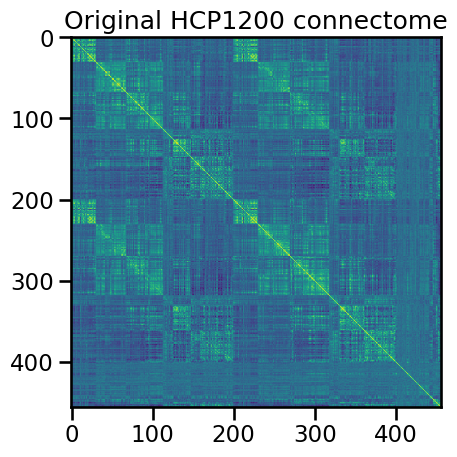

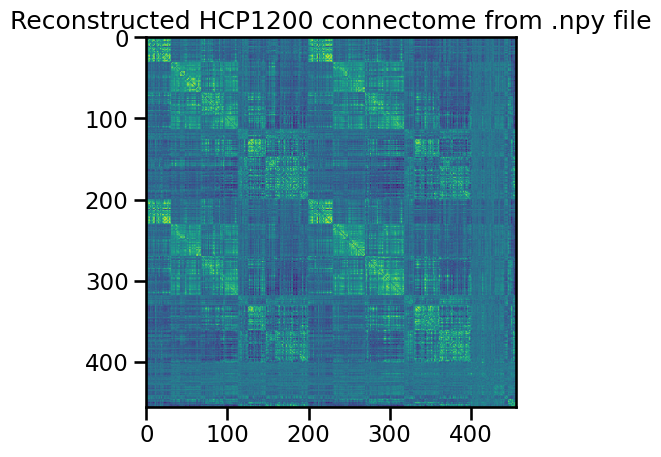

In [14]:
def process_and_verify_connectomes(connectomes, path, name):
    """
    Process connectomes, save upper triangle data, and verify reconstruction.
    
    Args:
        connectomes: List of connectome matrices
        path: Path to save .npy files
        name: Name of the parcellation (e.g. 'BHA2-183')
    """
    # Plot first connectome
    sub0_connectome = connectomes[0]
    plt.figure()
    plt.imshow(sub0_connectome)
    plt.title(f"Original {name} connectome")

    # Load first subject's connectome from saved .npy file using memory mapping
    connectomes_upper = np.load(f'{path}/npy/connectomes_upper.npy', mmap_mode='r')
    sub0_connectome_from_file = connectomes_upper[0]
    print(f"{name} shape:", sub0_connectome_from_file.shape)

    # Reconstruct full symmetric connectome from upper triangle
    n = int((1 + np.sqrt(1 + 8*len(sub0_connectome_from_file)))/2)
    reconstructed = np.zeros((n,n))
    idx = np.triu_indices(n, k=1)
    reconstructed[idx] = sub0_connectome_from_file
    reconstructed = reconstructed + reconstructed.T

    plt.figure()
    plt.imshow(reconstructed)
    plt.title(f"Reconstructed {name} connectome from .npy file")

    # Get indices of upper triangle
    triu_rows, triu_cols = np.triu_indices(n, k=1)

    # Create dictionary mapping (row,col) tuples to 1D array indices
    idx_map = {(i,j): idx for idx, (i,j) in enumerate(zip(triu_rows, triu_cols))}
    print(f"Number of upper triangle elements: {len(idx_map)}")

    # Save index mapping dictionary to file
    np.save(f'{path}/npy/upper_triangle_index_map.npy', idx_map)
    print(f"Saved upper triangle index mapping to {path}/npy/upper_triangle_index_map.npy")

    # Check all values match between reconstructed and memory mapped
    all_match = True
    for i in range(n):
        for j in range(i+1, n):  # Only check upper triangle
            # Get value from original connectome
            orig_value = reconstructed[i,j]
            
            # Get value from memory mapped file using index map
            mapped_idx = idx_map[(i,j)]
            mmap_value = sub0_connectome_from_file[mapped_idx]
            
            if not np.allclose(orig_value, mmap_value):
                print(f"Mismatch at edge ({i},{j}):")
                print(f"Original value: {orig_value:.4f}")
                print(f"Memory mapped value: {mmap_value:.4f}")
                all_match = False
                break
        if not all_match:
            break

    print(f"\nChecking all values in upper triangle for {name}:")
    print(f"All values match: {all_match}")

# Process each HCP1200 parcellation
process_and_verify_connectomes(HCP1200_connectomes, os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_fMRI/', 'HCP1200')



### Plot random connectomes

In [15]:
def plot_random_connectomes(connectomes, n_rows, max_rois):
    """
    Plot a grid of random connectomes from the dataset.
    
    Args:
        connectomes: List of connectome matrices
        n_rows: Number of rows/columns in the grid (total plots will be n_rows^2)
        max_rois: Maximum number of ROIs to show in each connectome plot
    """
    # Create a figure with n_rows x n_rows subplots
    fig, axes = plt.subplots(n_rows, n_rows, figsize=(2*n_rows, 2*n_rows))
    
    # Convert list to numpy array and get random indices
    connectome_array = np.array(connectomes)
    n_plots = n_rows * n_rows
    random_indices = np.random.choice(len(connectome_array), size=n_plots, replace=False)
    
    # Plot each connectome in the grid
    for idx, ax in enumerate(axes.flat):
        # Get random connectome and plot first max_rois x max_rois portion
        connectome = connectome_array[random_indices[idx]][:max_rois, :max_rois]
        im = ax.imshow(connectome, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
        ax.axis('off')  # Turn off axis labels
    
    # Add a colorbar that applies to all subplots
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f'{n_plots} Random HCP Cortical Connectomes (rsFC)', y=0.92)
    plt.show()

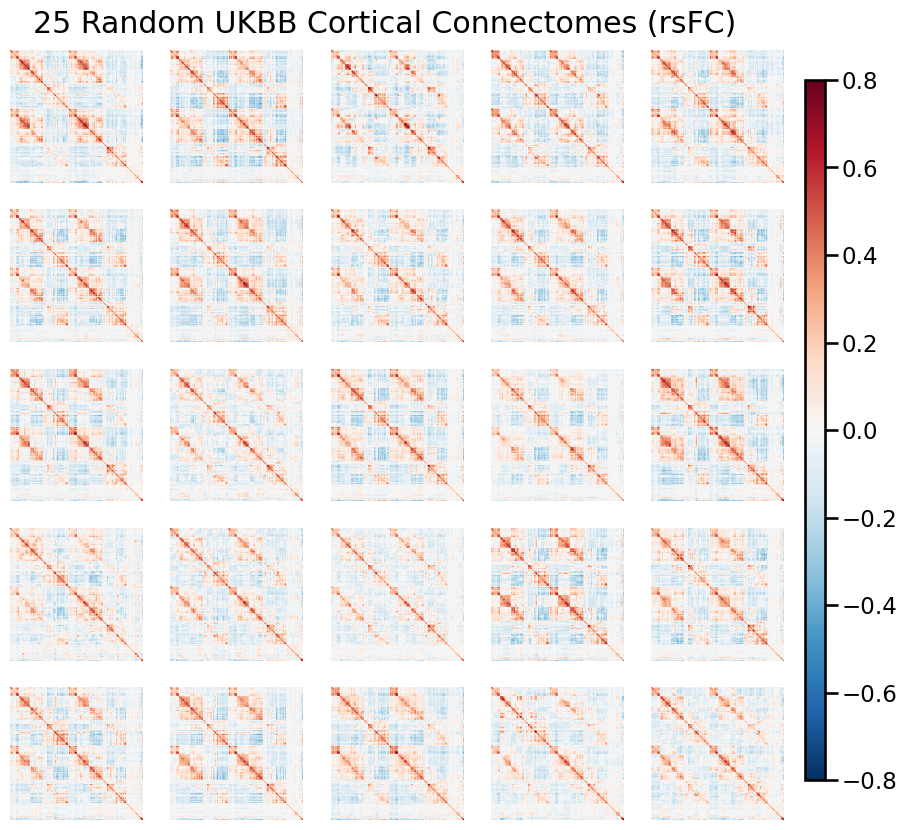

In [16]:
plot_random_connectomes(HCP1200_connectomes, n_rows=5, max_rois=456)

In [16]:
def plot_connectome_with_networks(connectome_mu, network_labels=None, n_rois=None, title=None):
    """
    Plot a connectome matrix with optional network labels and size limit.
    
    Args:
        connectome_mu: Average connectome matrix to plot
        network_labels: Optional list of network labels for each ROI
        n_rois: Optional number of ROIs to display (will show first n_rois x n_rois portion)
        title: Optional title for the plot. If None, uses default title.
    """
    plt.figure(figsize=(12, 10), dpi=200)
    
    # Limit connectome size if specified
    if n_rois is not None:
        connectome_mu = connectome_mu[:n_rois, :n_rois]
        if network_labels is not None:
            network_labels = network_labels[:n_rois]
    
    # Create the heatmap
    im = plt.imshow(connectome_mu, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    plt.colorbar()

    if network_labels is not None:
        # Draw lines between different adjacent labels
        prev_label = network_labels[0]
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                plt.axhline(y=i-0.5, color='black', linewidth=0.5)
                plt.axvline(x=i-0.5, color='black', linewidth=0.5)
                prev_label = network_labels[i]
        
        # Create tick positions and labels
        tick_positions = []
        tick_labels = []
        start_idx = 0
        prev_label = network_labels[0]
        
        for i in range(1, len(network_labels)):
            if network_labels[i] != prev_label:
                tick_positions.append((start_idx + i - 1) / 2)
                tick_labels.append(prev_label)
                start_idx = i
                prev_label = network_labels[i]
        
        # Add the last group
        tick_positions.append((start_idx + len(network_labels) - 1) / 2)
        tick_labels.append(prev_label)

        plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
        plt.yticks(tick_positions, tick_labels)

    else:
        # Add numerical ticks every 20 ROIs (or 10 if total ROIs <= 100)
        total_rois = connectome_mu.shape[0]
        tick_interval = 20 if total_rois <= 200 else 50
        tick_positions = np.arange(0, total_rois, tick_interval)
        plt.xticks(tick_positions, tick_positions)
        plt.yticks(tick_positions, tick_positions)

    if title is None:
        title = 'Average Cortical Connectome (rsFC)'
    plt.title(title)
    plt.tight_layout()
    plt.show()


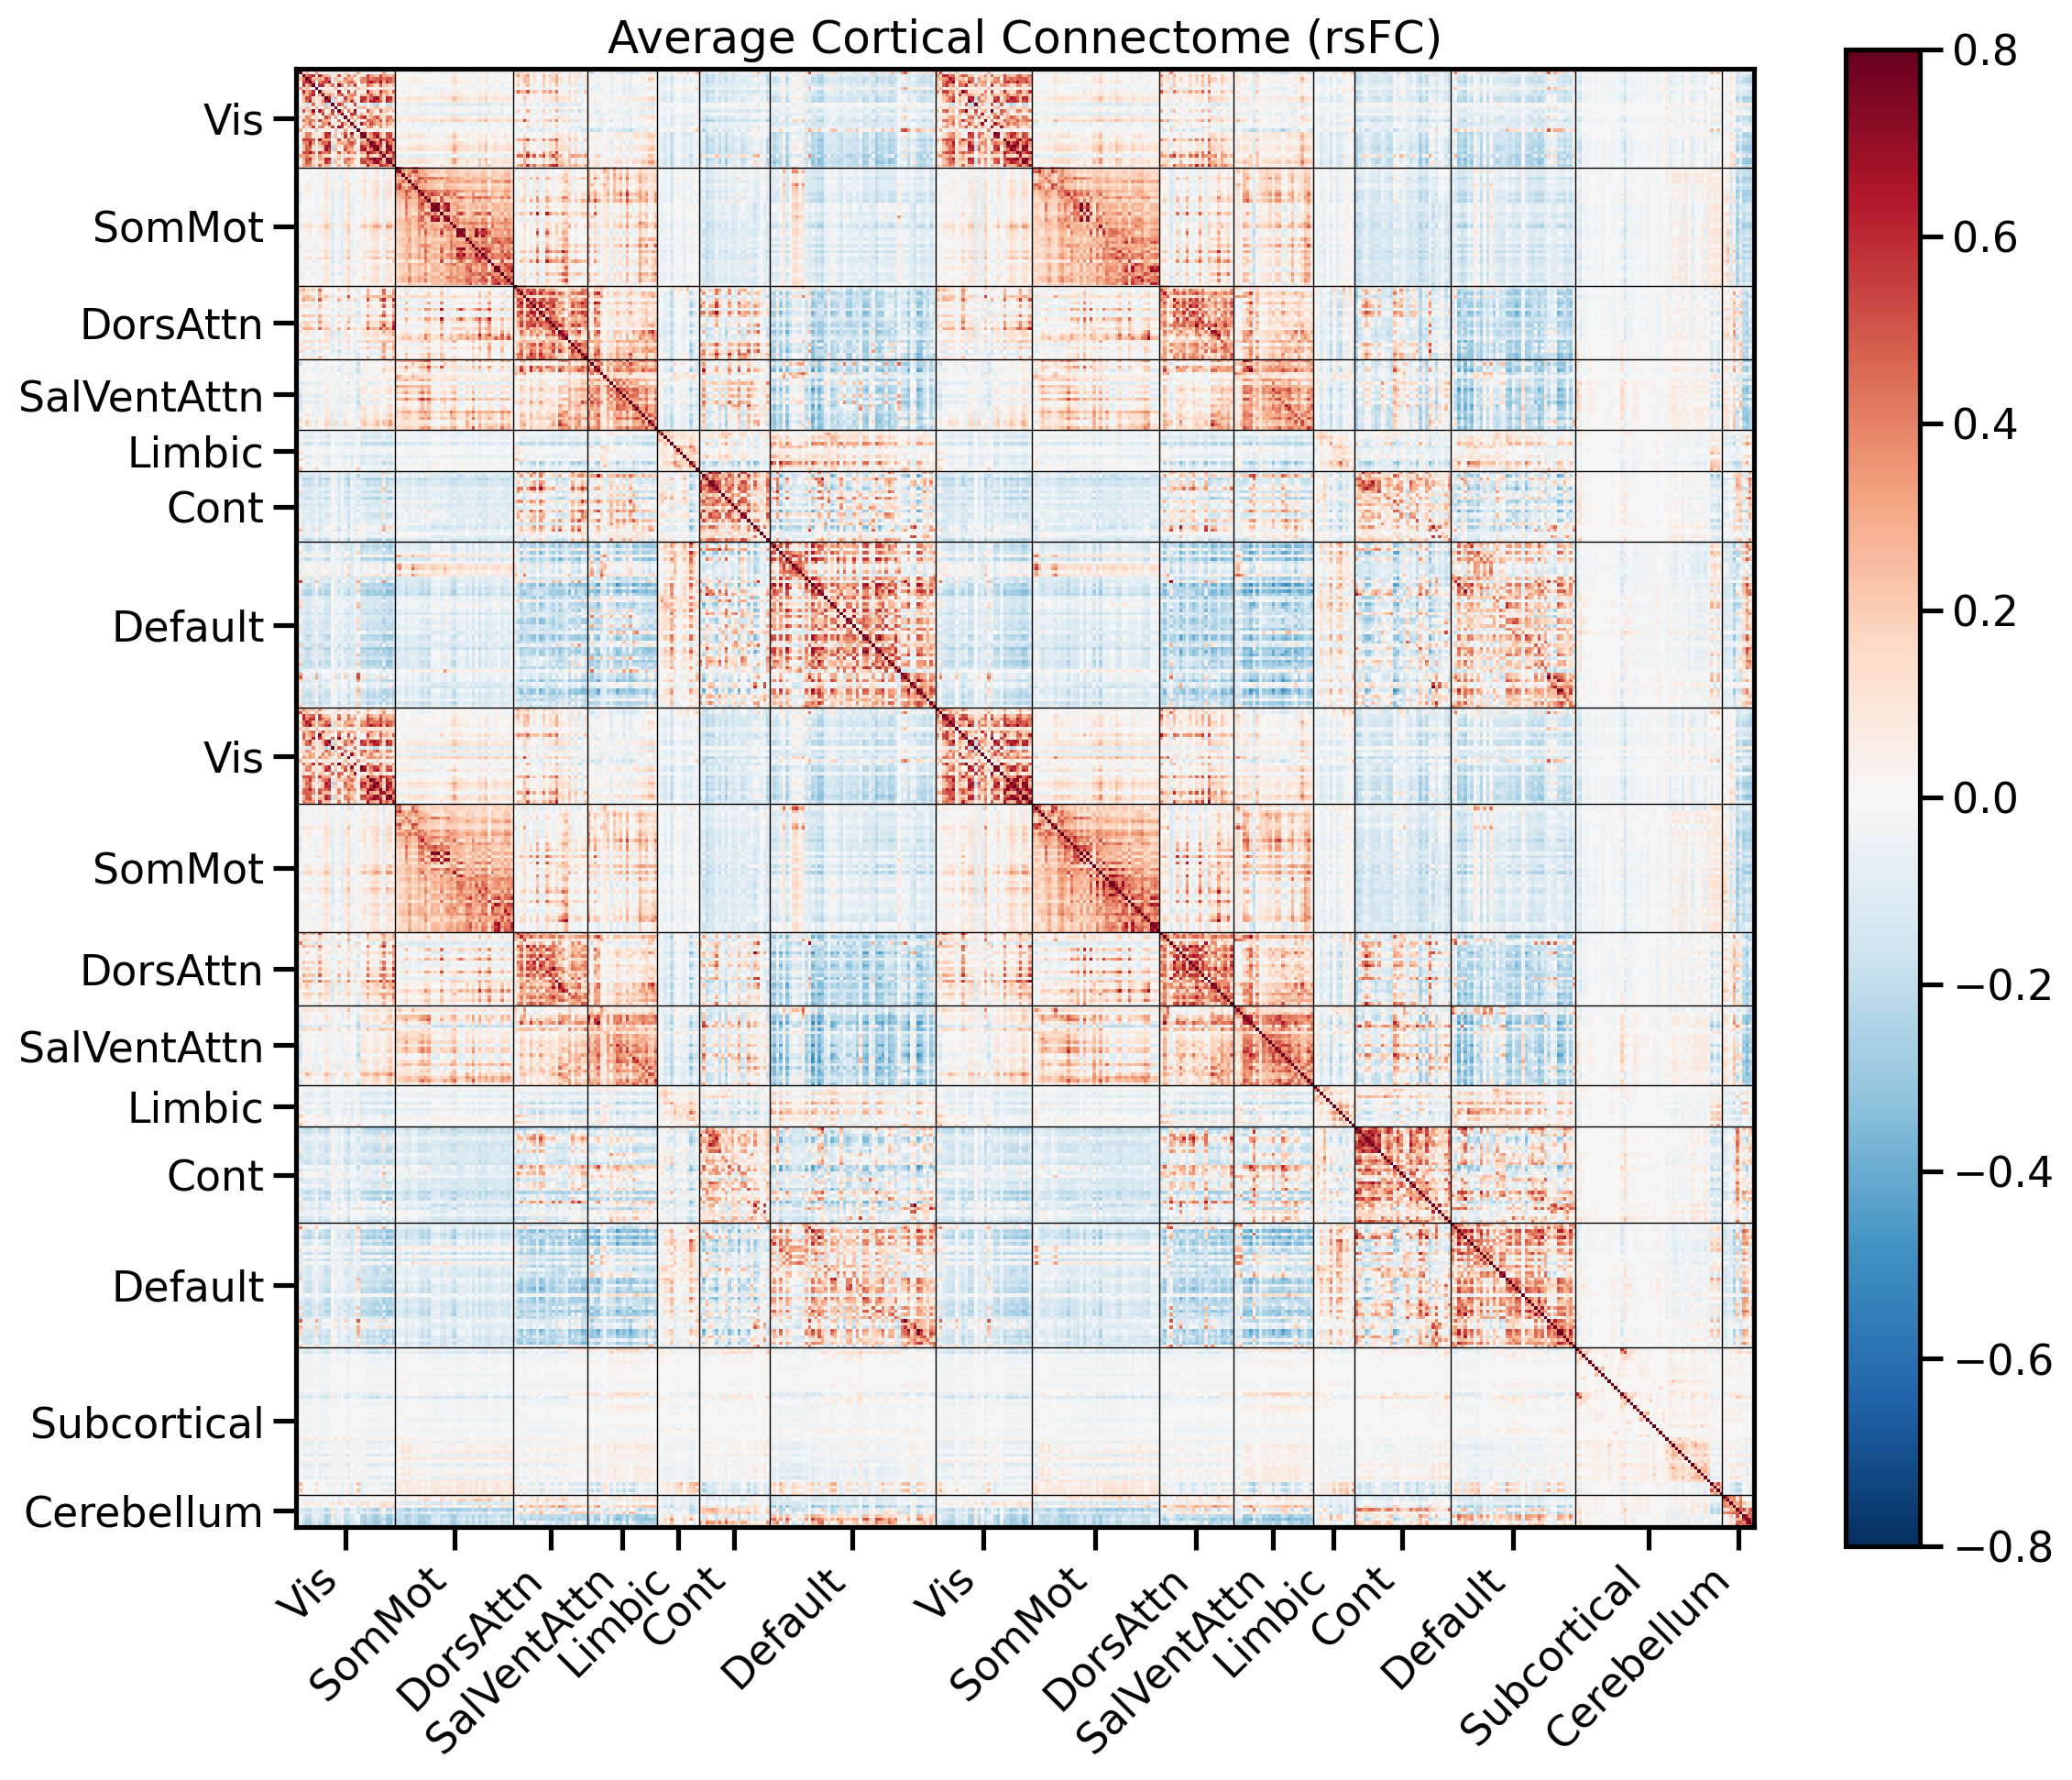

In [17]:
plot_connectome_with_networks(HCP1200_connectome_mu, network_labels=schaef456_network_labels)



## Evaluate stability

### Correlations

In [54]:
def calculate_connectome_correlations(connectomes):
    """
    Calculate correlations between each connectome and the population average.
    
    Args:
        connectomes (list): List of individual subject connectome matrices
        
    Returns:
        tuple: (mean correlation, overall p-value) if valid correlations exist,
               (None, None) otherwise
    """
    # Convert list of connectomes to array and calculate population average
    connectome_array = np.array(connectomes)
    pop_avg = np.mean(connectome_array, axis=0)
    
    # Calculate correlations between population average and each individual connectome
    correlations = []
    p_values = []
    for connectome in connectome_array:
        # Flatten the matrices to 1D arrays for correlation calculation
        pop_avg_flat = pop_avg.flatten()
        conn_flat = connectome.flatten()
        
        # Remove any pairs where either value is NaN or inf
        mask = ~(np.isnan(pop_avg_flat) | np.isnan(conn_flat) | 
                 np.isinf(pop_avg_flat) | np.isinf(conn_flat))
        pop_avg_clean = pop_avg_flat[mask]
        conn_clean = conn_flat[mask]
        
        if len(pop_avg_clean) > 0:  # Only calculate if we have valid data points
            try:
                # Calculate correlation and p-value
                corr, p_val = pearsonr(pop_avg_clean, conn_clean)
                print(f"Correlation: {corr:.3f}, p-value: {p_val:.3e}")
                correlations.append(corr)
                p_values.append(p_val)
            except Exception as e:
                print(f"Error calculating correlation: {str(e)}")
                continue

    if correlations:  # Only calculate statistics if we have valid correlations
        # Calculate mean correlation
        mean_corr = np.mean(correlations)
        # Calculate overall p-value using Fisher's method with all valid p-values
        overall_p = scipy.stats.combine_pvalues(p_values)[1]

        print(f"Mean correlation with population average: {mean_corr:.3f}")
        print(f"Overall p-value: {overall_p:.3e}")
        return mean_corr, overall_p
    else:
        print("No valid correlations could be calculated")
        return None, None

In [55]:
calculate_connectome_correlations(HCP1200_connectomes)

Correlation: 0.835, p-value: 0.000e+00
Correlation: 0.864, p-value: 0.000e+00
Correlation: 0.815, p-value: 0.000e+00
Correlation: 0.862, p-value: 0.000e+00
Correlation: 0.836, p-value: 0.000e+00
Correlation: 0.785, p-value: 0.000e+00
Correlation: 0.876, p-value: 0.000e+00
Correlation: 0.755, p-value: 0.000e+00
Correlation: 0.781, p-value: 0.000e+00
Correlation: 0.870, p-value: 0.000e+00
Correlation: 0.838, p-value: 0.000e+00
Correlation: 0.820, p-value: 0.000e+00
Correlation: 0.843, p-value: 0.000e+00
Correlation: 0.848, p-value: 0.000e+00
Correlation: 0.786, p-value: 0.000e+00
Correlation: 0.768, p-value: 0.000e+00
Correlation: 0.782, p-value: 0.000e+00
Correlation: 0.857, p-value: 0.000e+00
Correlation: 0.832, p-value: 0.000e+00
Correlation: 0.796, p-value: 0.000e+00
Correlation: 0.785, p-value: 0.000e+00
Correlation: 0.830, p-value: 0.000e+00
Correlation: 0.857, p-value: 0.000e+00
Correlation: 0.854, p-value: 0.000e+00
Correlation: 0.866, p-value: 0.000e+00
Correlation: 0.676, p-val

  statistic = -2 * np.sum(np.log(pvalues))



Mean correlation with population average: 0.826
Overall p-value: 0.000e+00


(0.8264908230498167, 0.0)

### Residuals

In [56]:
def compute_connectome_residuals(individual_connectomes, population_average, n_regions=None):
    """
    Compute residuals between individual connectomes and population average.
    
    Parameters:
    -----------
    individual_connectomes : list
        List of individual connectivity matrices
    population_average : numpy.ndarray 
        Population average connectivity matrix
    n_regions : int, optional
        Number of regions to include in analysis. If None, uses all regions (default None)
        
    Returns:
    --------
    numpy.ndarray
        1D array of flattened residuals
    """
    # Get max number of regions from population average shape
    max_regions = population_average.shape[0]
    
    # Use all regions if n_regions not specified or is larger than max
    n_regions = min(n_regions, max_regions) if n_regions is not None else max_regions
    
    # Select subset of regions
    subset_connectomes = [conn[:n_regions, :n_regions] for conn in individual_connectomes]
    pop_avg_subset = population_average[:n_regions, :n_regions]
    
    print(f"Original connectome shape: {individual_connectomes[0].shape}")
    print(f"Subset connectome shape: {subset_connectomes[0].shape}")

    # Convert to numpy array and compute residuals
    connectome_array = np.array(subset_connectomes)
    residuals = connectome_array - pop_avg_subset

    # Flatten residuals into 1D array
    return residuals.flatten()

def plot_residual_distribution(all_residuals):
    """
    Plot distribution of residuals between individual connectomes and population average.
    Tests and visualizes if the distribution is Gaussian.
    
    Parameters:
    -----------
    all_residuals : numpy.ndarray
        1D array of flattened residuals
    """
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot histogram without KDE
    sns.histplot(all_residuals, kde=False, stat='density', bins=100)
    
    # Fit normal distribution and plot
    mu, std = np.nanmean(all_residuals), np.nanstd(all_residuals)
    
    plt.title('Distribution of Residuals All Connectomes vs. Population Average')
    plt.xlabel('Residual Value')
    plt.ylabel('Density')
    plt.legend()
    
    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(all_residuals[~np.isnan(all_residuals)])
    
    # Add summary statistics and normality test results as text
    stats_text = f'Mean: {mu:.3f}\n'
    stats_text += f'Std: {std:.3f}\n'
    
    stats_text += f'\nShapiro-Wilk Test:\n'
    stats_text += f'Statistic: {statistic:.3f}\n'
    stats_text += f'p-value: {p_value:.3e}\n'
    stats_text += f'Distribution is {"Normal" if p_value > 0.05 else "Not Normal"}'
    
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

Original connectome shape: (456, 456)
Subset connectome shape: (456, 456)


  warnings.warn("p-value may not be accurate for N > 5000.")



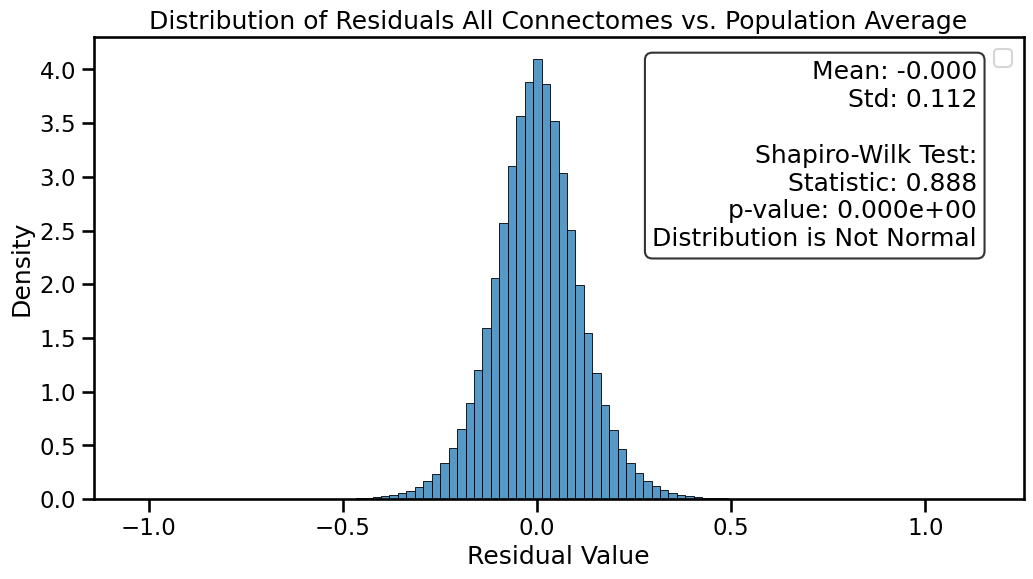

In [57]:
all_HCP1200_residuals = compute_connectome_residuals(HCP1200_connectomes, HCP1200_connectome_mu)
plot_residual_distribution(all_HCP1200_residuals)


In [22]:
def plot_random_edge_distribution(connectomes, max_regions, avg_connectome):
    """
    Plot distribution of values for a random edge in the connectome and test for normality.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    max_regions : int
        Number of regions to subset (e.g. first 100)
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Get random indices for row and column within max_regions
    row_idx = np.random.randint(0, max_regions)
    col_idx = np.random.randint(0, max_regions)
    
    # Get distribution of values for this edge across subjects
    edge_values = connectome_array[:, row_idx, col_idx]
    
    # Perform Shapiro-Wilk test for normality
    statistic, p_value = stats.shapiro(edge_values)
    
    # Get max possible range from population average
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot histogram with KDE
    sns.histplot(edge_values, kde=True, stat='count', bins=30)
    plt.xlim(x_range)
    
    # Add vertical line for population average
    avg_value = avg_connectome[row_idx, col_idx]
    plt.axvline(x=avg_value, color='r', linestyle='--', 
                label=f'Population Average: {avg_value:.3f}')
    
    plt.title(f'Distribution of Edge Values for Regions ({row_idx}, {col_idx})')
    plt.xlabel('Connectivity Value')
    plt.ylabel('Count')
    plt.legend()
    
    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()

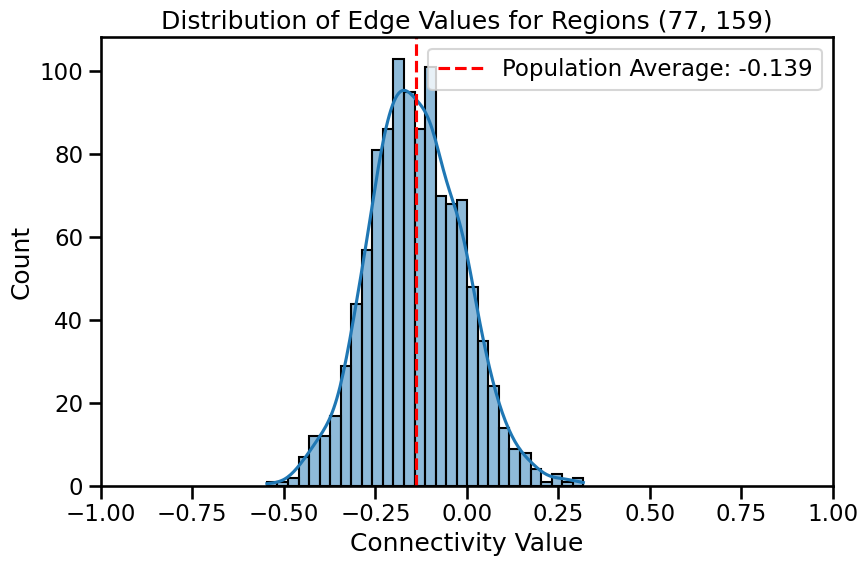

In [23]:
plot_random_edge_distribution(HCP1200_connectomes, 456, HCP1200_connectome_mu)

### Connectome subset KDEs

In [24]:
def plot_edge_distributions(connectomes, starting_roi, next_rois, avg_connectome):
    """
    Plot KDE distributions for all edges in the upper triangle of the connectome.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    starting_roi : int
        Starting ROI index (0-based)
    next_rois : int
        Number of subsequent ROIs to plot
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Calculate ending ROI index
    end_roi = starting_roi + next_rois
    
    # First plot the subsetted connectome
    subset_connectome = avg_connectome[starting_roi:end_roi, starting_roi:end_roi]
    
    # Create mask for upper triangle
    mask = np.tril(np.ones_like(subset_connectome))
    
    # Create masked array
    masked_connectome = np.ma.array(subset_connectome, mask=mask)
    
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(masked_connectome, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    plt.colorbar()
    plt.title(f'Average Cortical Connectome Subset (ROIs {starting_roi}-{end_roi-1})')
    
    # Set integer ticks
    plt.xticks(range(0, next_rois, 5), range(starting_roi, end_roi, 5))
    plt.yticks(range(0, next_rois, 5), range(starting_roi, end_roi, 5))
    
    plt.show()
    
    # KDE part
    # Create figure with subplots for upper triangle
    n_rows = next_rois - 1
    n_cols = next_rois - 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))  # Made height equal to width
    
    # Get max possible range from population average for consistent scaling
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Plot KDE for each edge in upper triangle
    plot_idx = 0
    for i in range(starting_roi, end_roi):
        for j in range(i+1, end_roi):
            # Get row and column index in subplot grid
            row = i - starting_roi
            col = j - starting_roi - 1
            
            # Get distribution of values for this edge across subjects
            edge_values = connectome_array[:, i, j]
            
            # Get average value for background color
            avg_value = avg_connectome[i, j]
            
            # Set background color based on average value
            axes[row, col].set_facecolor(plt.cm.RdBu_r((avg_value + 1) / 2))
            
            # Plot KDE with thicker lines and black border
            sns.kdeplot(edge_values, ax=axes[row, col], color='black', linewidth=5)  # Increased from 3 to 5
            axes[row, col].spines['top'].set_visible(True)
            axes[row, col].spines['right'].set_visible(True)
            axes[row, col].spines['bottom'].set_visible(True)
            axes[row, col].spines['left'].set_visible(True)
            axes[row, col].spines['top'].set_color('black')
            axes[row, col].spines['right'].set_color('black')
            axes[row, col].spines['bottom'].set_color('black')
            axes[row, col].spines['left'].set_color('black')
            axes[row, col].spines['top'].set_linewidth(2)
            axes[row, col].spines['right'].set_linewidth(2)
            axes[row, col].spines['bottom'].set_linewidth(2)
            axes[row, col].spines['left'].set_linewidth(2)
            axes[row, col].set_xlim(x_range)
            
            # Make subplot square by setting aspect ratio to 'equal'
            axes[row, col].set_aspect(1.0/axes[row, col].get_data_ratio())
            
            # Add vertical line for population average with thicker line
            axes[row, col].axvline(x=avg_value, color='blue', linestyle='--', linewidth=5)  # Increased from 3 to 5
            
            # Remove all labels and ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
            
            plot_idx += 1
    
    # Remove empty subplots in lower triangle
    for i in range(n_rows):
        for j in range(n_cols):
            if j <= i:
                axes[i,j].remove()
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

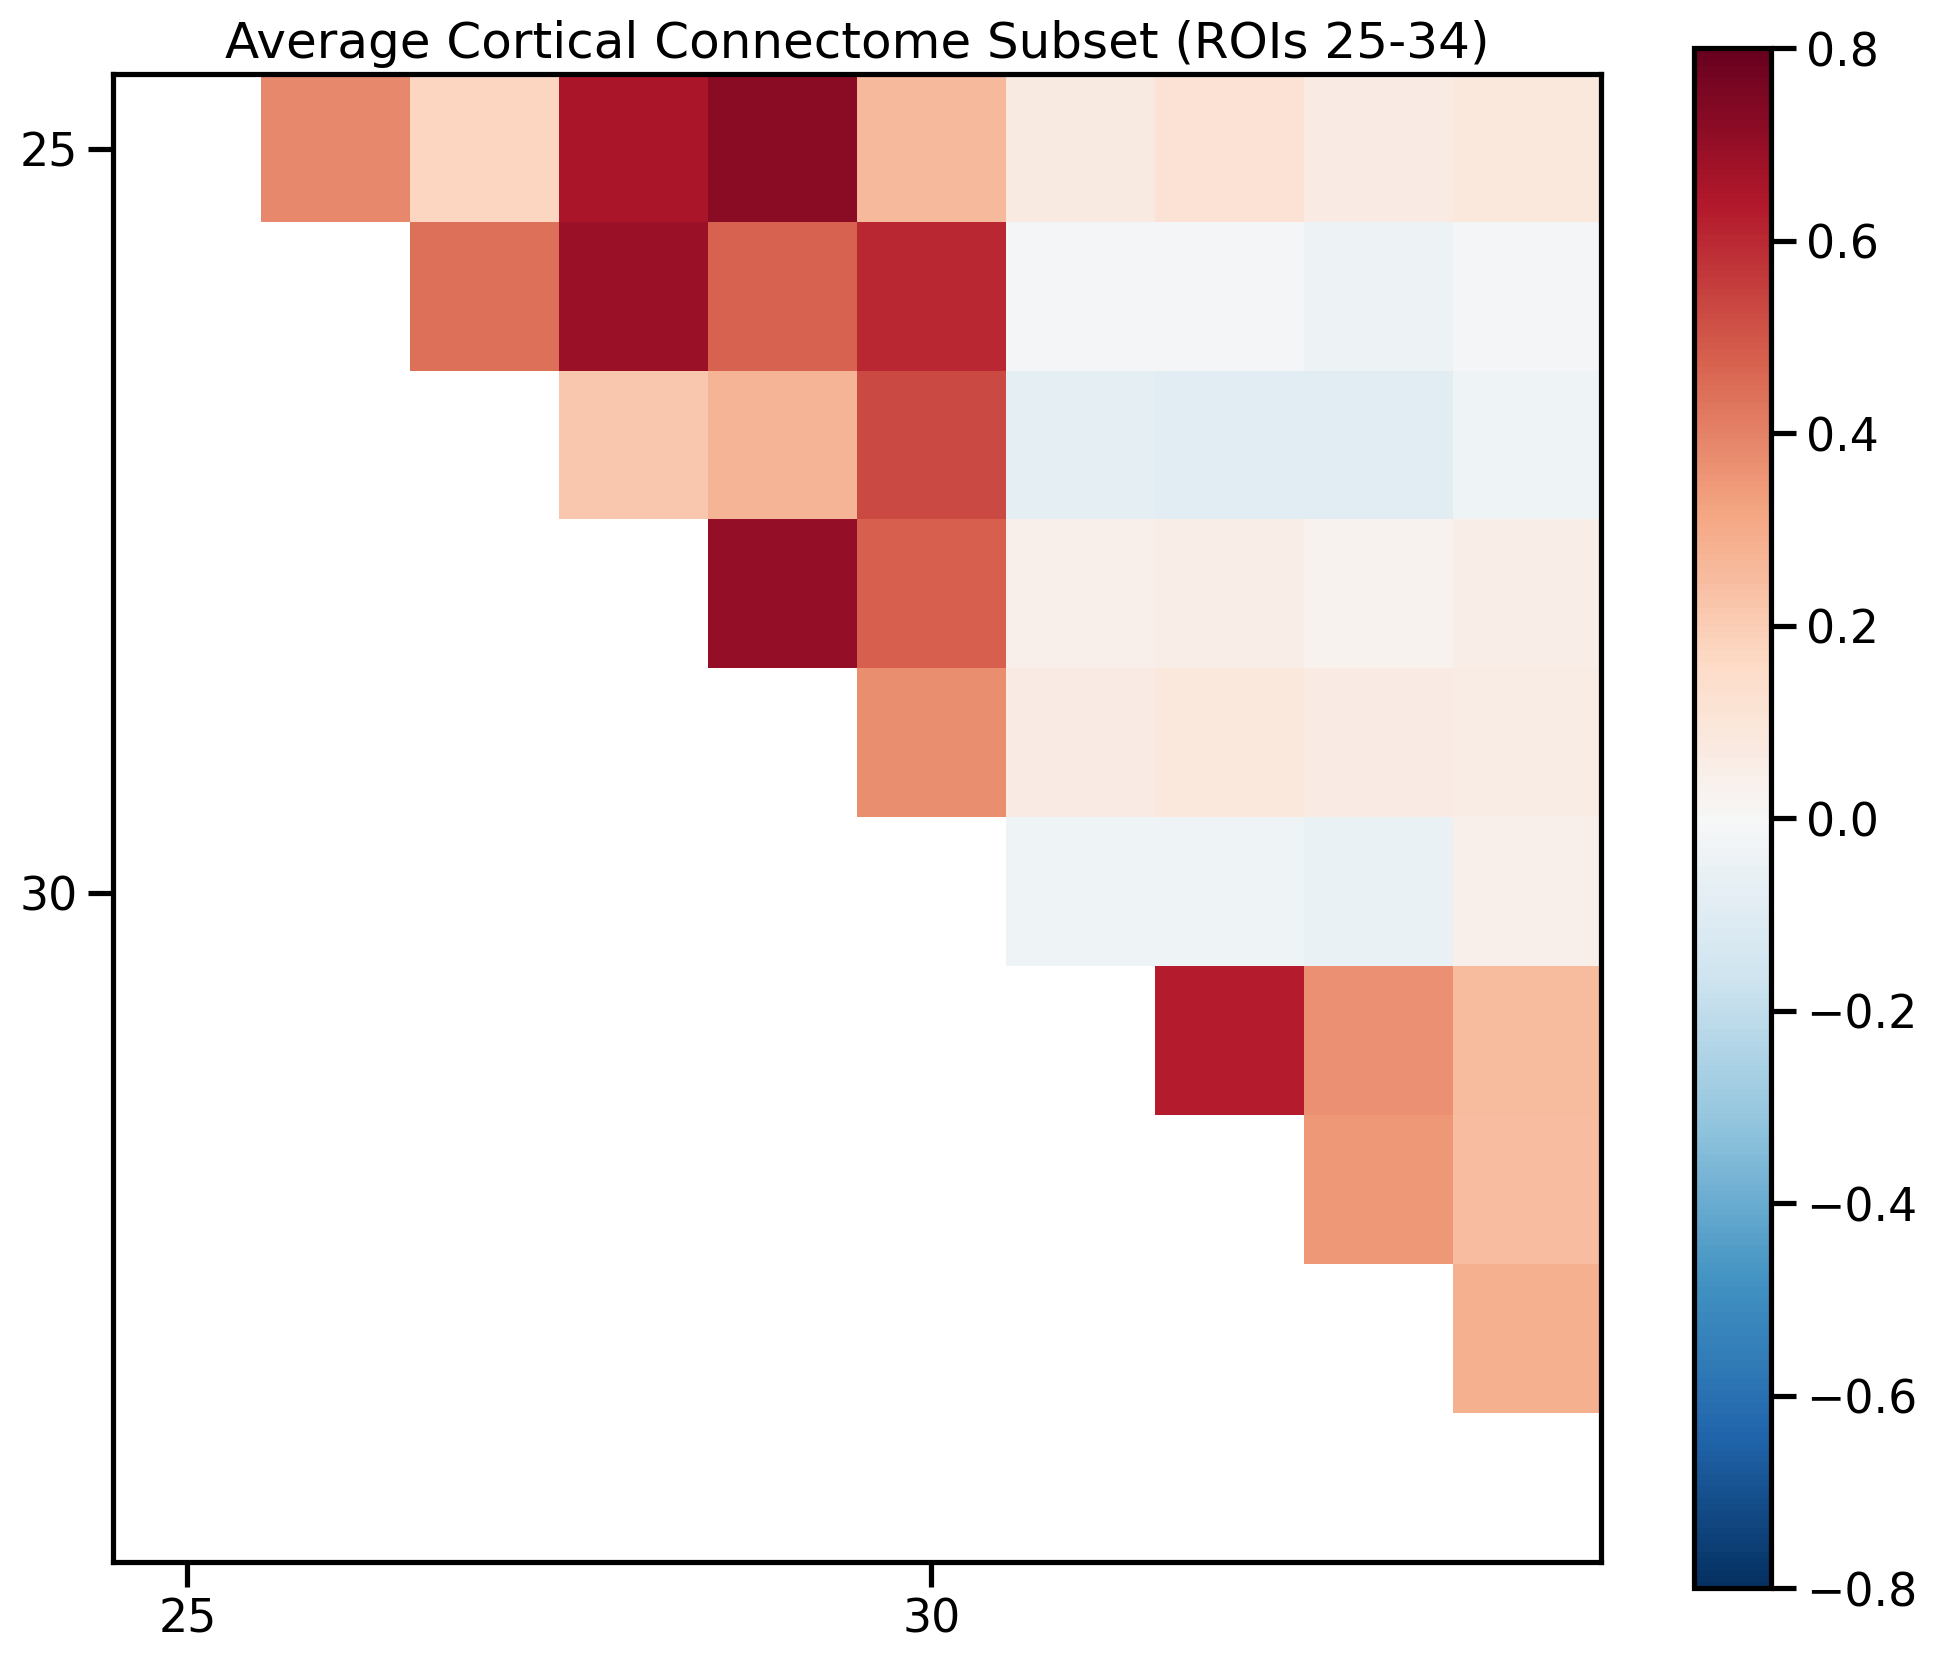

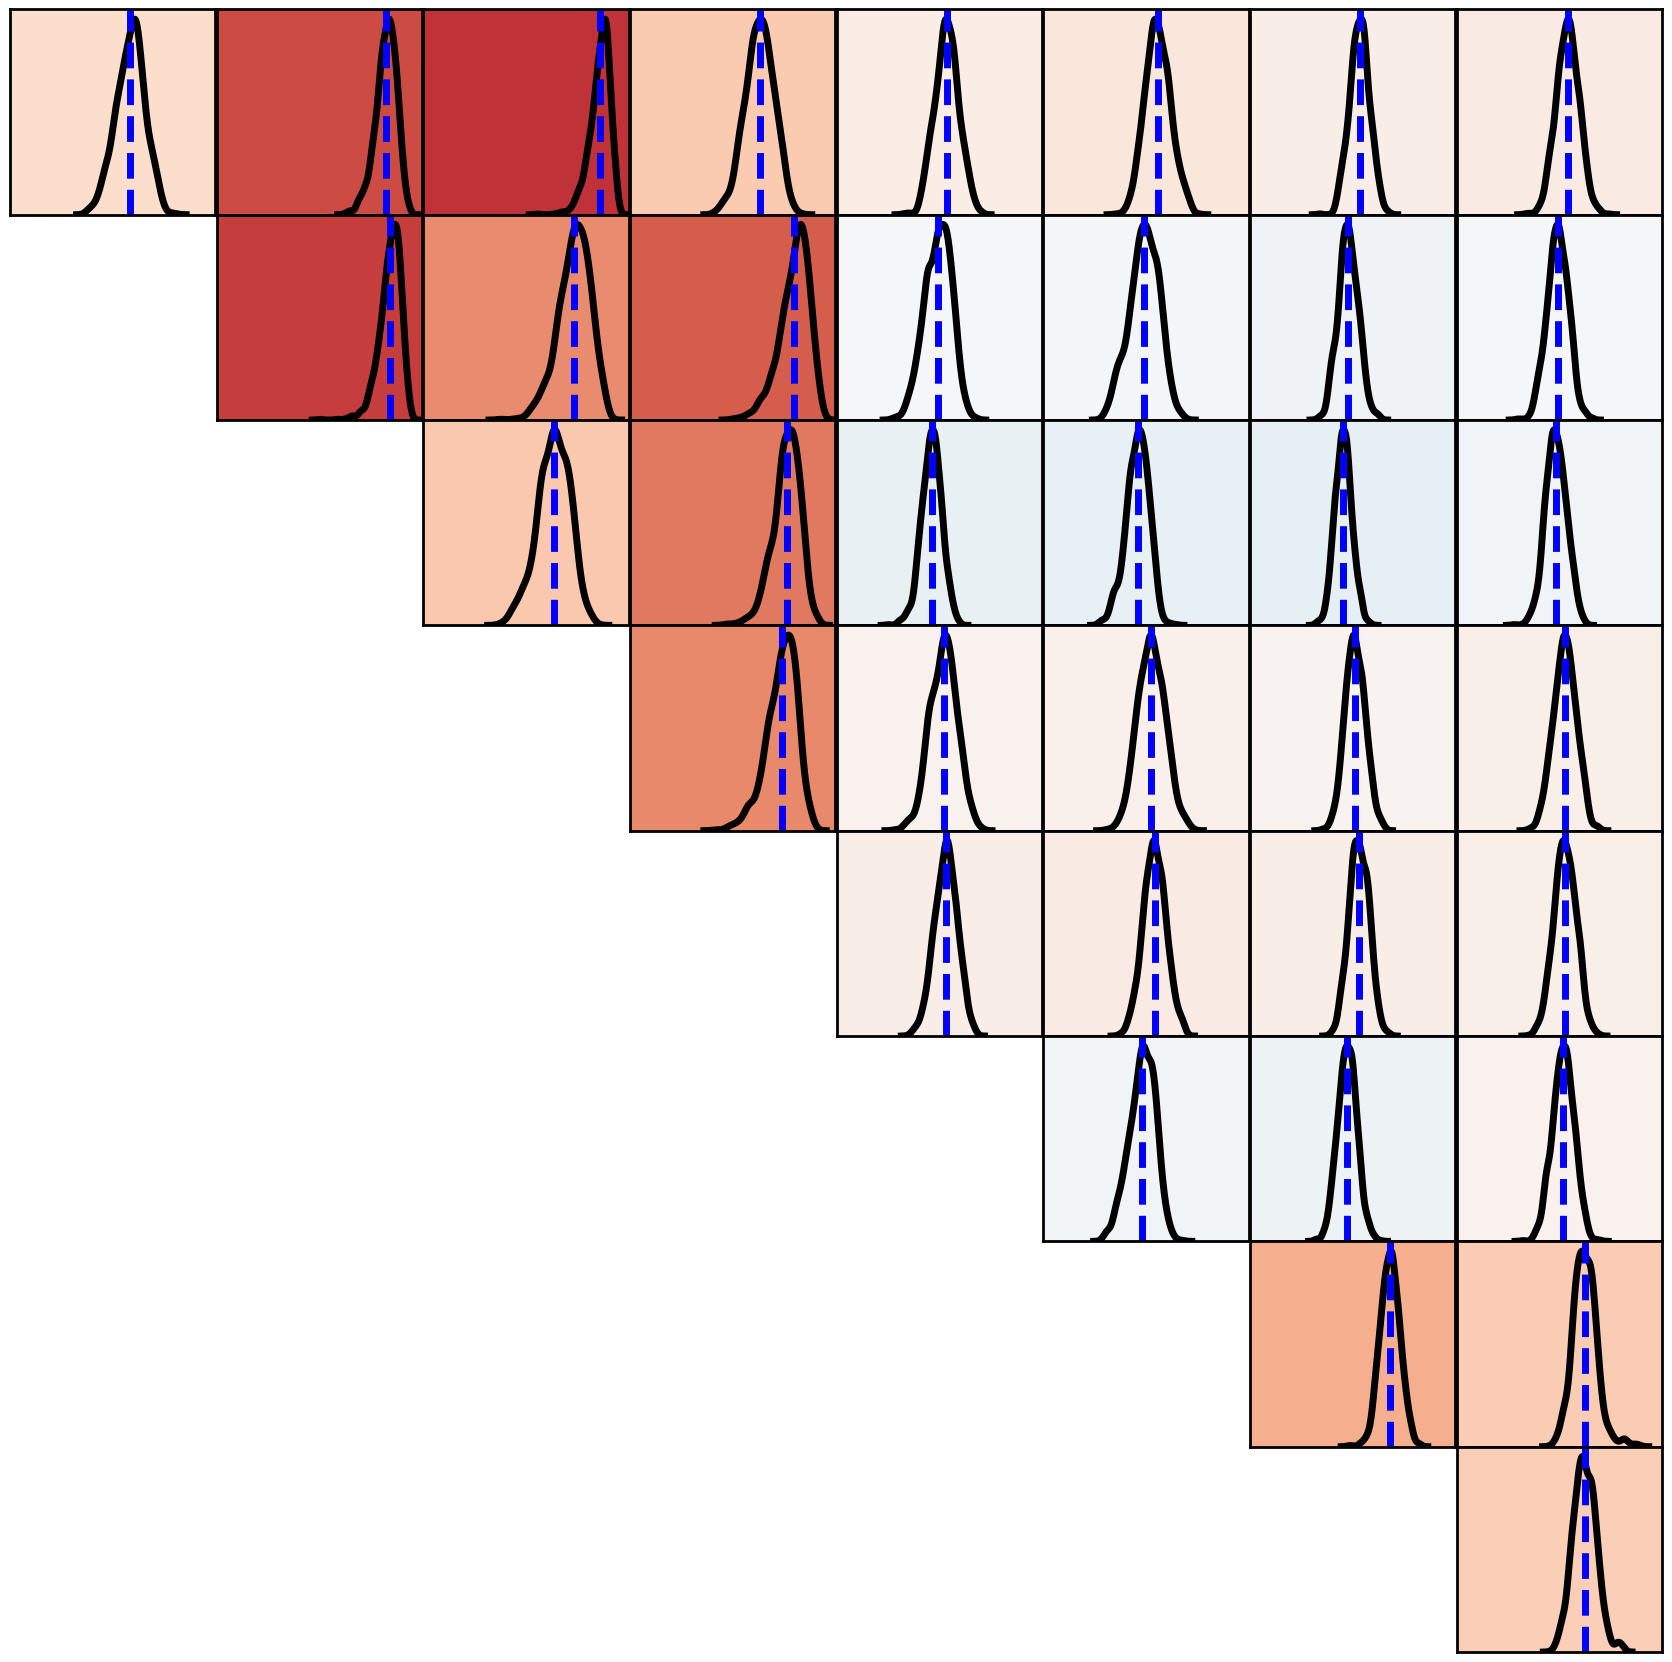

In [25]:
plot_edge_distributions(HCP1200_connectomes, starting_roi=25, next_rois=10, avg_connectome=HCP1200_connectome_mu)

In [26]:
def plot_edge_distributions_full(connectomes, starting_roi_y, starting_roi_x, next_rois, avg_connectome):
    """
    Plot KDE distributions for edges between two specified ranges of ROIs.
    
    Parameters:
    -----------
    connectomes : list
        List of connectivity matrices
    starting_roi_y : int
        Starting ROI index for y-axis (0-based)
    starting_roi_x : int
        Starting ROI index for x-axis (0-based) 
    next_rois : int
        Number of subsequent ROIs to plot on each axis
    avg_connectome : numpy.ndarray
        Population average connectome matrix
    """
    # Convert to numpy array and subset
    connectome_array = np.array(connectomes)
    n_subjects = len(connectome_array)
    
    # Calculate ending ROI indices
    end_roi_y = starting_roi_y + next_rois
    end_roi_x = starting_roi_x + next_rois
    
    # First plot the subsetted connectome
    subset_connectome = avg_connectome[starting_roi_y:end_roi_y, starting_roi_x:end_roi_x]
    
    plt.figure(figsize=(12, 10), dpi=200)
    plt.imshow(subset_connectome, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
    plt.colorbar()
    plt.title(f'Average Cortical Connectome Subset\n(ROIs {starting_roi_y}-{end_roi_y-1} × {starting_roi_x}-{end_roi_x-1})')
    
    # Set integer ticks
    plt.xticks(range(0, next_rois, 5), range(starting_roi_x, end_roi_x, 5))
    plt.yticks(range(0, next_rois, 5), range(starting_roi_y, end_roi_y, 5))
    
    plt.show()
    
    # KDE part
    # Create figure with subplots for all connections between the two ranges
    n_rows = next_rois
    n_cols = next_rois
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))
    
    # Get max possible range from population average for consistent scaling
    max_abs_val = np.max(np.abs(avg_connectome))
    x_range = (-max_abs_val, max_abs_val)
    
    # Plot KDE for each edge between the two ranges
    for i in range(starting_roi_y, end_roi_y):
        for j in range(starting_roi_x, end_roi_x):
            # Get row and column index in subplot grid
            row = i - starting_roi_y
            col = j - starting_roi_x
            
            # Get distribution of values for this edge across subjects
            edge_values = connectome_array[:, i, j]
            
            # Get average value for background color
            avg_value = avg_connectome[i, j]
            
            # Set background color based on average value
            axes[row, col].set_facecolor(plt.cm.RdBu_r((avg_value + 1) / 2))
            
            # Plot KDE with thicker lines and black border
            sns.kdeplot(edge_values, ax=axes[row, col], color='black', linewidth=5)
            axes[row, col].spines['top'].set_visible(True)
            axes[row, col].spines['right'].set_visible(True)
            axes[row, col].spines['bottom'].set_visible(True)
            axes[row, col].spines['left'].set_visible(True)
            axes[row, col].spines['top'].set_color('black')
            axes[row, col].spines['right'].set_color('black')
            axes[row, col].spines['bottom'].set_color('black')
            axes[row, col].spines['left'].set_color('black')
            axes[row, col].spines['top'].set_linewidth(2)
            axes[row, col].spines['right'].set_linewidth(2)
            axes[row, col].spines['bottom'].set_linewidth(2)
            axes[row, col].spines['left'].set_linewidth(2)
            axes[row, col].set_xlim(x_range)
            
            # Make subplot square by setting aspect ratio to 'equal'
            axes[row, col].set_aspect(1.0/axes[row, col].get_data_ratio())
            
            # Add vertical line for population average with thicker line
            axes[row, col].axvline(x=avg_value, color='blue', linestyle='--', linewidth=5)
            
            # Remove all labels and ticks
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            axes[row, col].set_xlabel('')
            axes[row, col].set_ylabel('')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

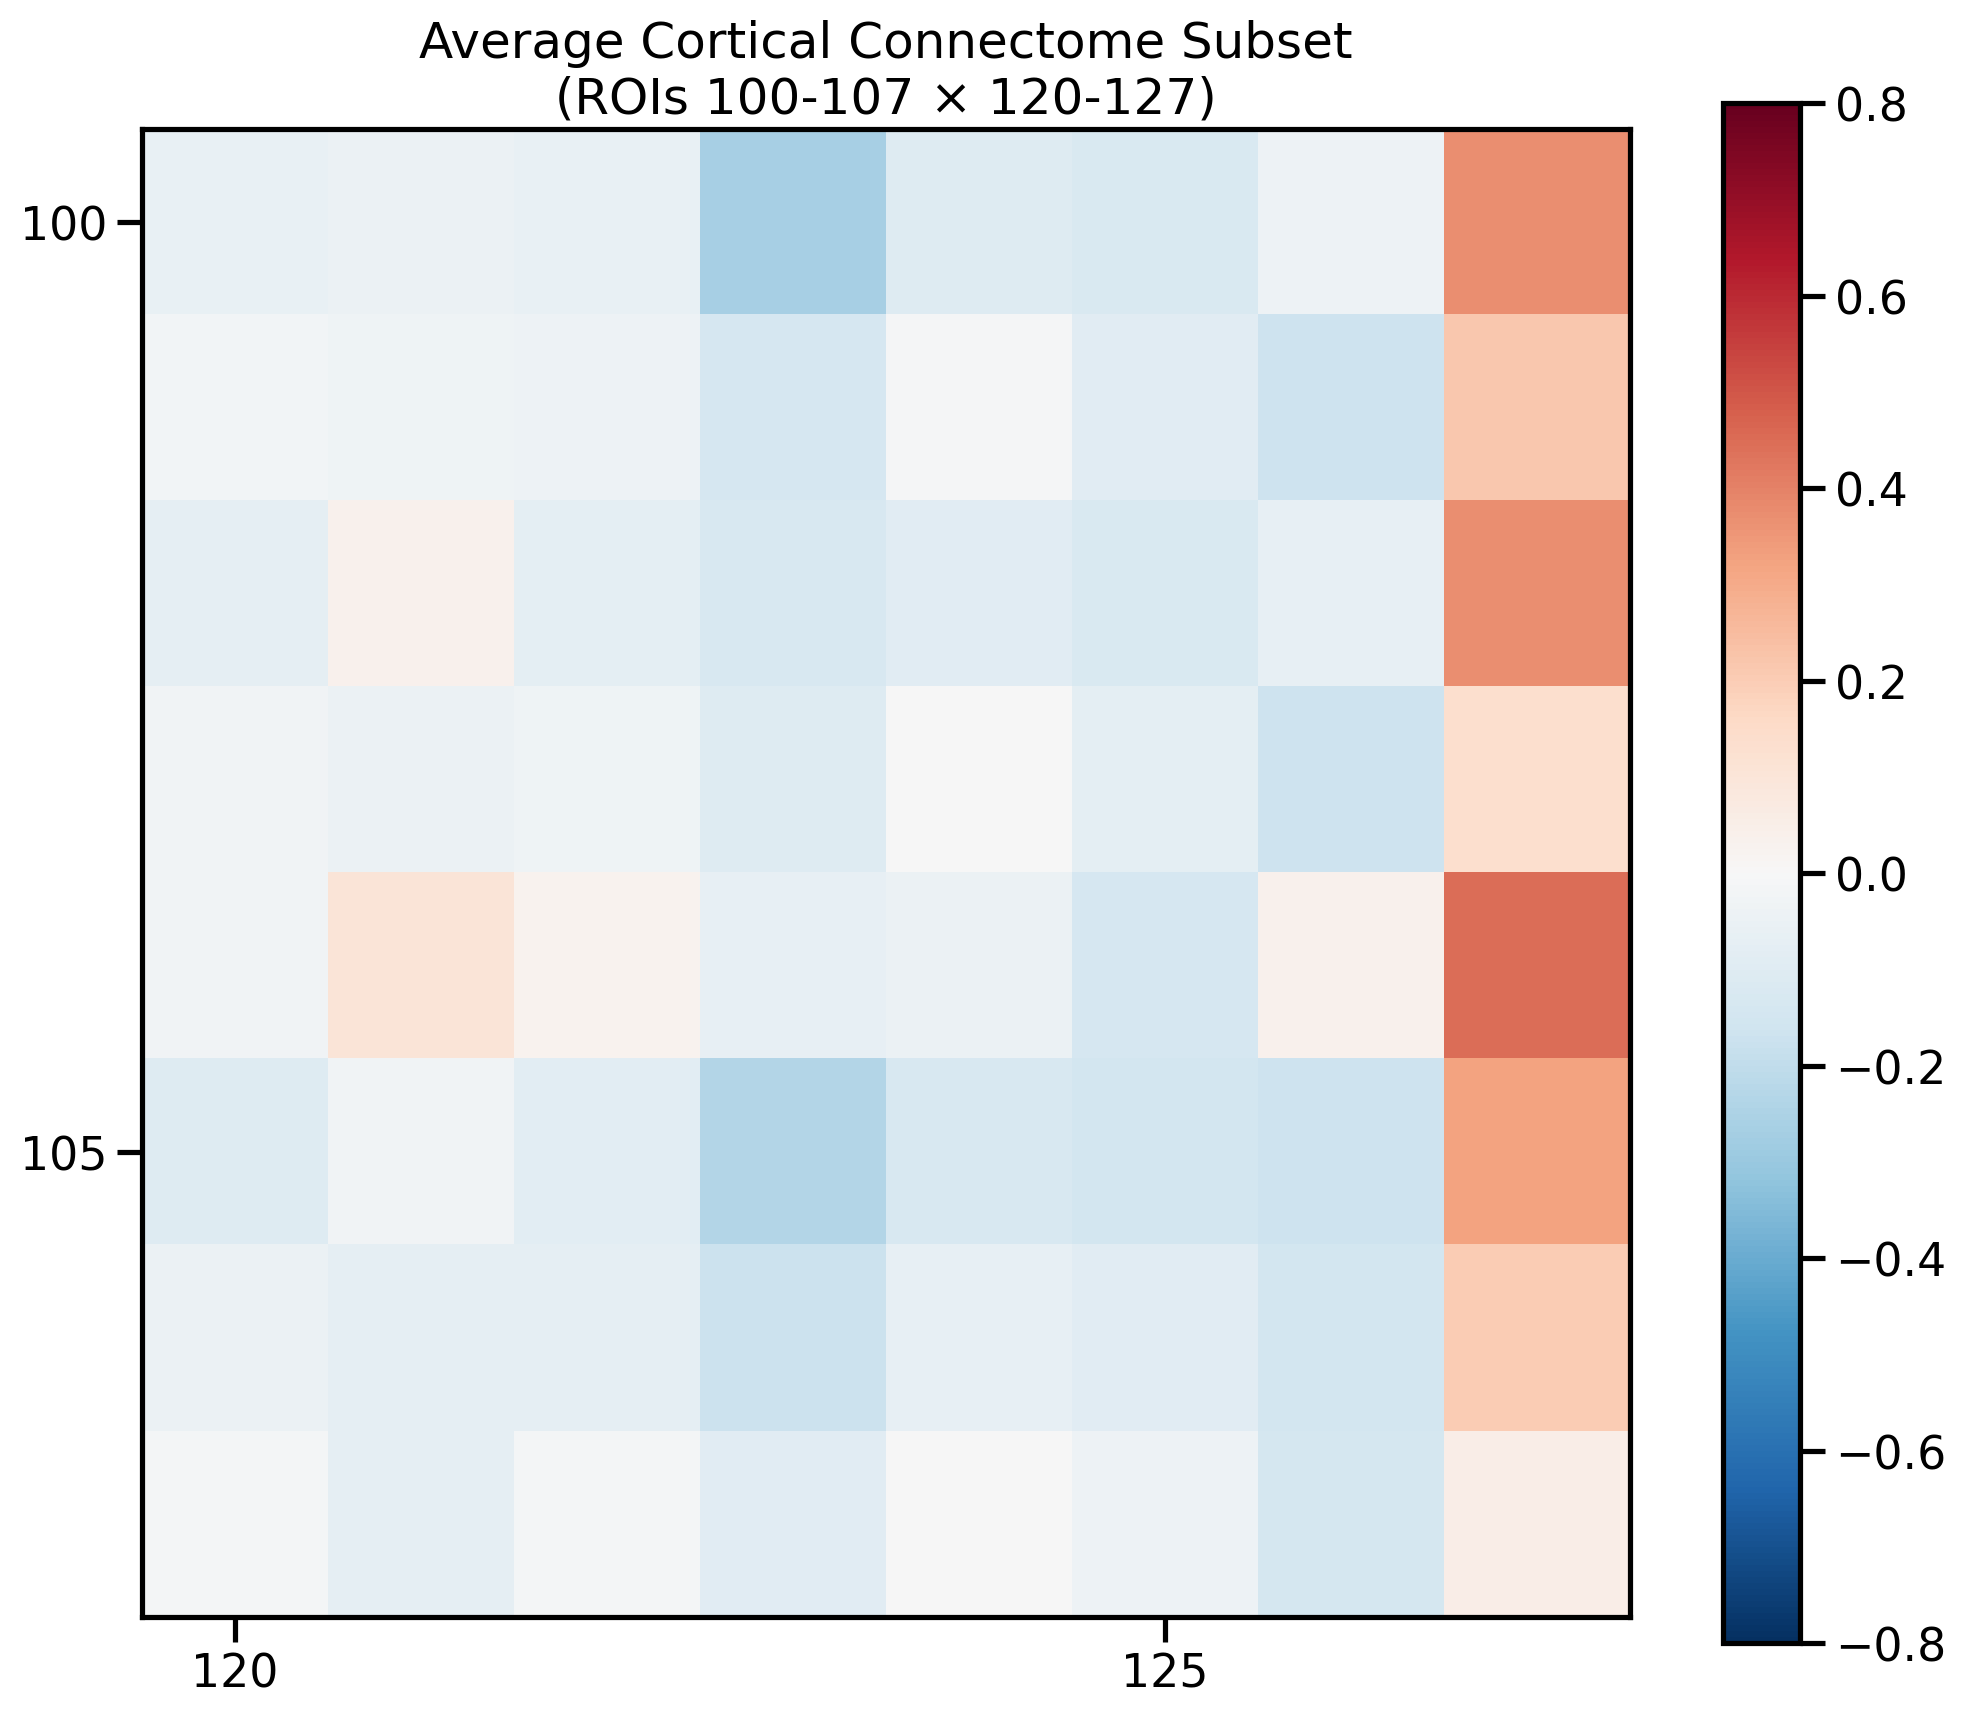

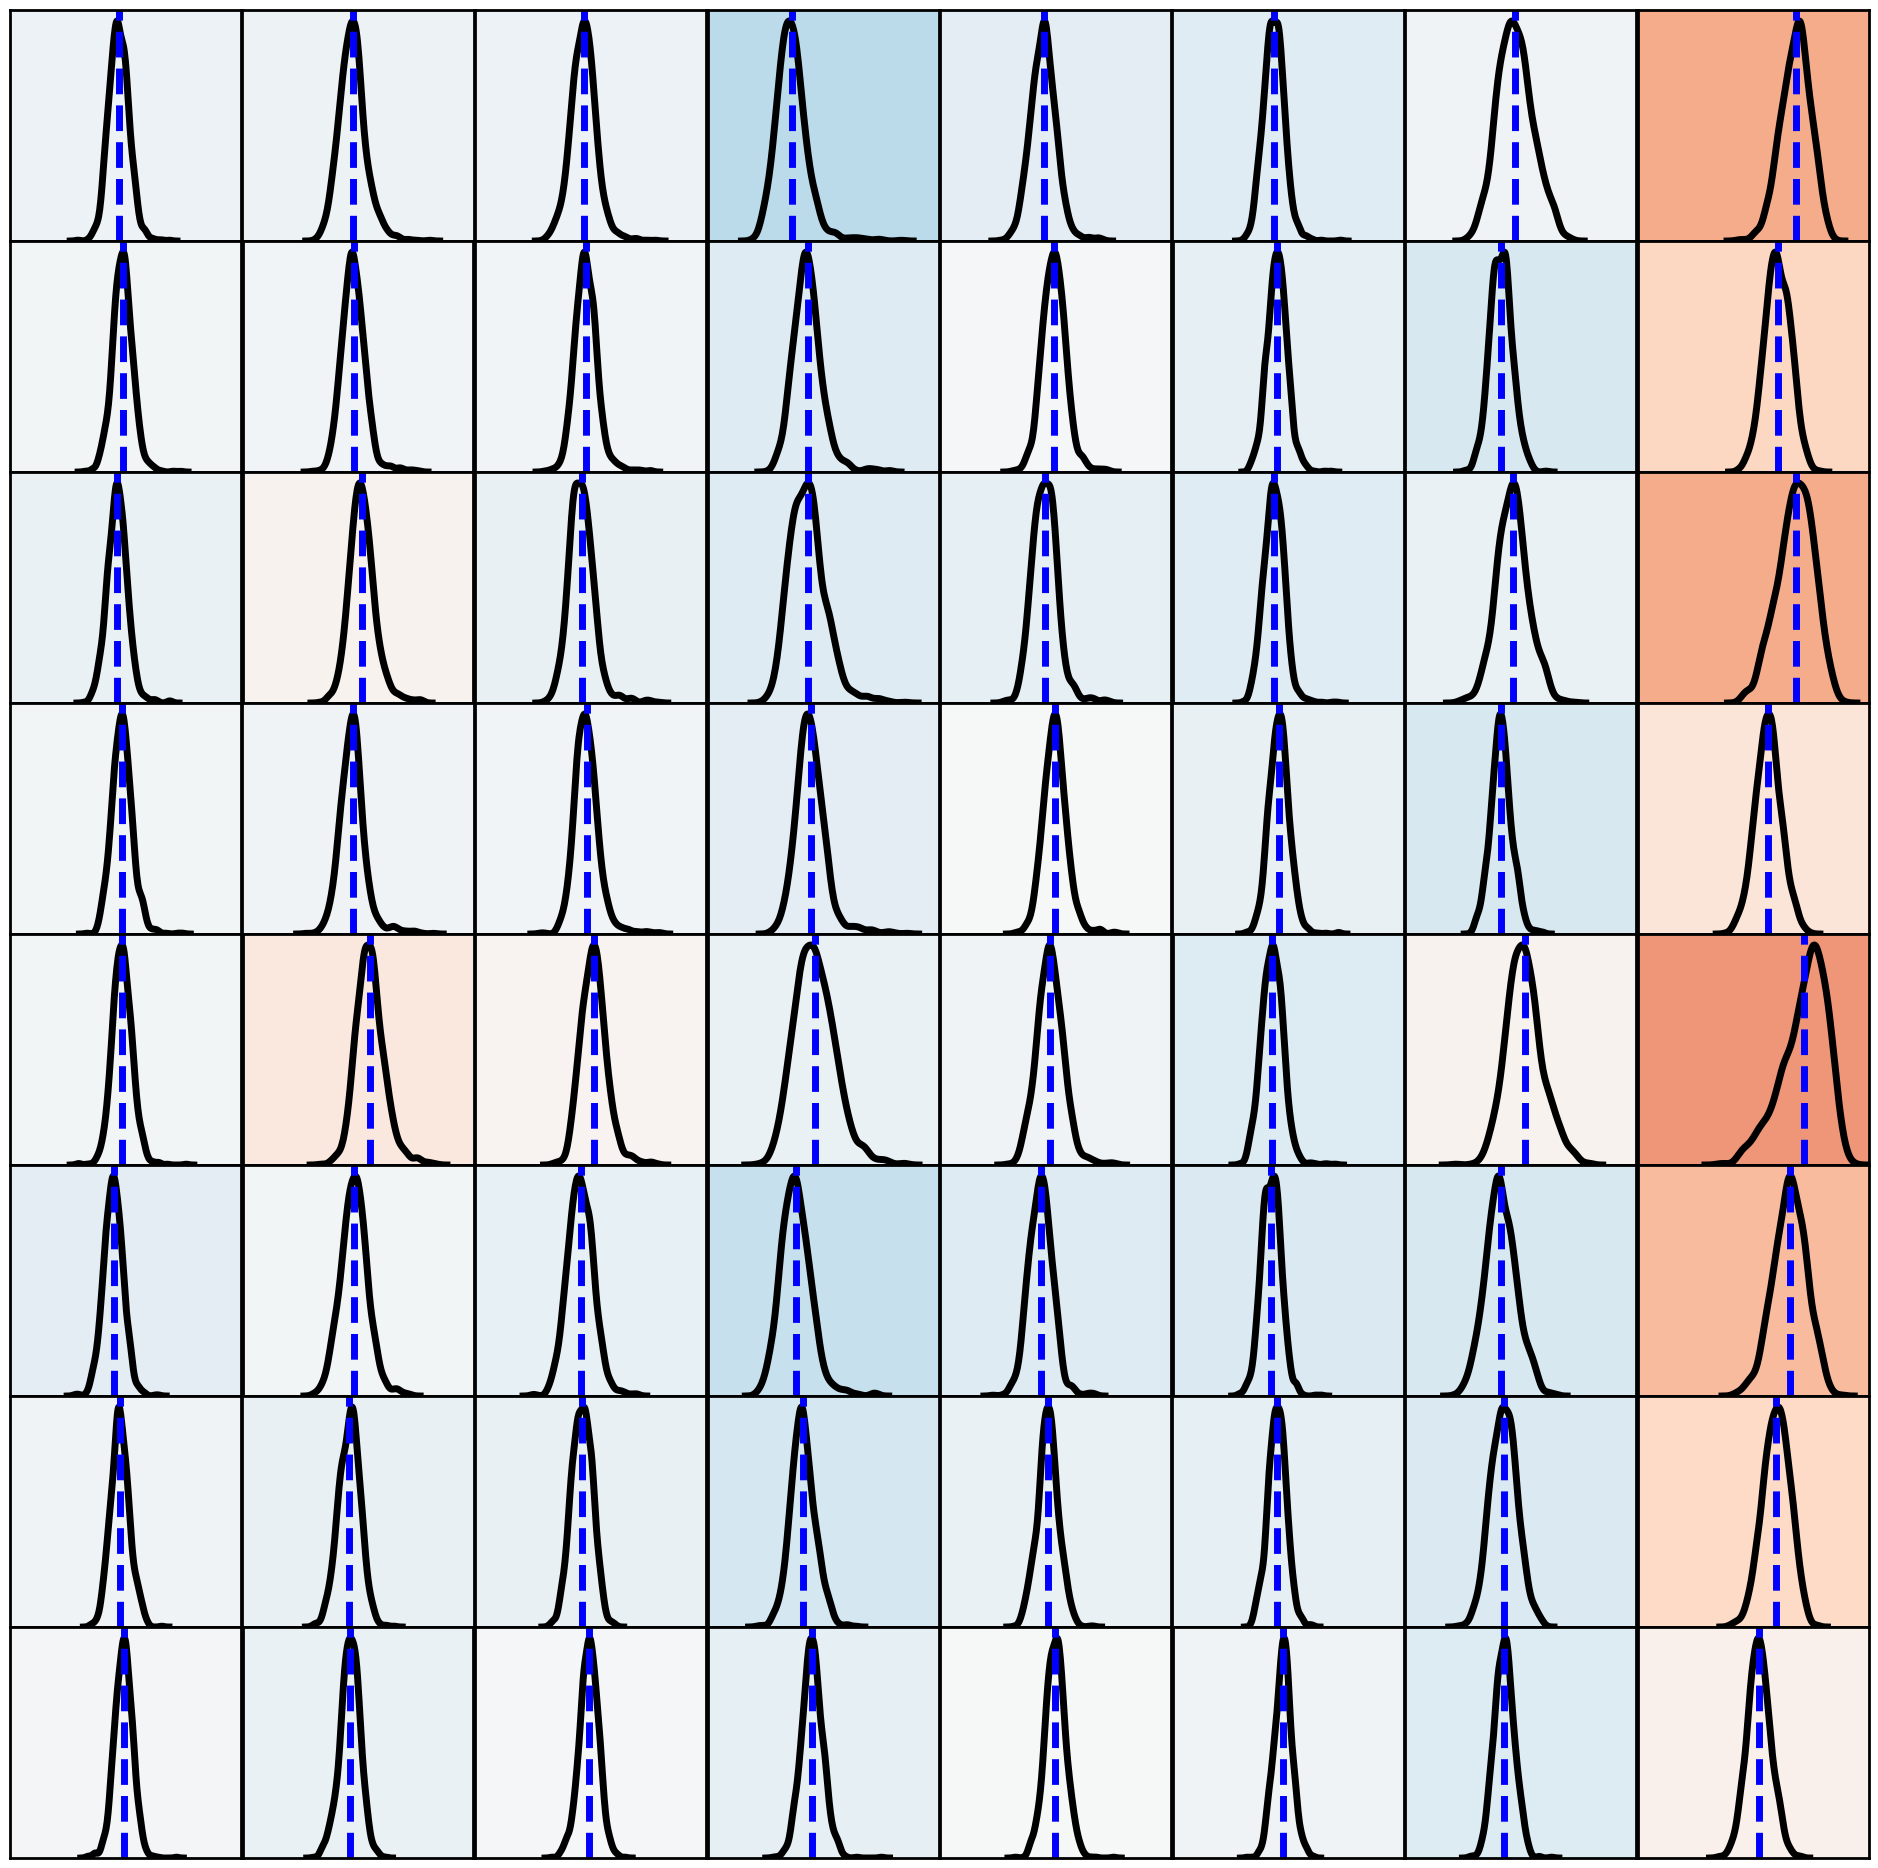

In [27]:
plot_edge_distributions_full(HCP1200_connectomes, 100, 120, 8, HCP1200_connectome_mu)